In [36]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math
import random as rd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import warnings

In [2]:
train_data = pd.read_csv("train.csv")
# drop these columns ("x96", "x97", "x98", "x1021", "x1098", "x1099" are columns with no data)
train_X = train_data.drop(["health", "personid", "uniqueid", "year", "x96", "x97", "x98", "x1021", "x1098", "x1099"], axis = 1)

# change all numerical values to float type
train_X = train_X.astype(float)

# drop NA that accounts a certain percentage
threshold = math.floor(0.05 * 17398)
train_X_less_na = train_X.dropna(thresh=threshold, axis=1)
print(len(train_X_less_na.columns))
print(train_X.shape)

1015
(17398, 1199)


In [3]:
# find numerical variables and store them in columns_to_drop 
category_vars = []
for c in train_X_less_na:
    if len(pd.unique(train_X_less_na[c])) < 14:
        category_vars.append(c)

print(len(category_vars))

836


In [4]:
# Impute our data by using the mean of a column as the missing values

train_X_less_na_imp = train_X_less_na.copy()

for name in train_X_less_na_imp.columns:
    if (name in category_vars):
        mode = train_X_less_na_imp[name].mode()
        for i in range(0, len(train_X_less_na_imp[name])):
            if (np.isnan(train_X_less_na_imp.at[i, name])):
                train_X_less_na_imp.at[i, name] = rd.choices(mode, k=1)[0]
    else:
        mean = train_X_less_na_imp[name].mean()
        for i in range(0, len(train_X_less_na_imp[name])):
            if (np.isnan(train_X_less_na_imp.at[i, name])):
                train_X_less_na_imp.at[i, name] = mean


# for c in train_X_less_na_imp:
    #if c in category_vars:
     #   train_X_less_na_imp[c].fillna(train_X_less_na_imp[c].mode(),inplace=True)
    # else:
     #   train_X_less_na_imp[c].fillna(train_X_less_na_imp[c].mean(),inplace=True)
        
# check if there is still any NAs
for c in train_X_less_na_imp:
    if train_X_less_na_imp[c].isnull().any():
        print(c)

In [5]:
# scale train_X_less_na_imp to fit One class SVM
train_X_scaled = train_X_less_na_imp.copy()

for c in train_X_scaled:
    if c not in category_vars:
        if (max(train_X_scaled[c]) > 1) or (min(train_X_scaled[c]) < 0):
            train_X_scaled[c] = (train_X_scaled[c]-train_X_scaled[c].mean())/train_X_scaled[c].std()
        
train_X_scaled = pd.get_dummies(train_X_scaled, columns = category_vars, drop_first = True) # change categorical variables to indicator variables

print(len(train_X_scaled.columns))

3147


In [6]:
# outliers for outcomes in class = 1
one_class_svm_1 = OneClassSVM(gamma='scale', nu=0.01)
train_X_scaled_1 = train_X_scaled[train_data.health==1]
one_class_svm_1.fit(train_X_scaled_1)
outliers_1 = one_class_svm_1.predict(train_X_scaled_1) # outliers are indicated as -1, inliers are indicated as 1

# outliers for outcomes in class = 2
one_class_svm_2 = OneClassSVM(gamma='scale', nu=0.01)
train_X_scaled_2 = train_X_scaled[train_data.health==2]
one_class_svm_2.fit(train_X_scaled_2)
outliers_2 = one_class_svm_2.predict(train_X_scaled_2) # outliers are indicated as -1, inliers are indicated as 1

# outliers for outcomes in class = 3
one_class_svm_3 = OneClassSVM(gamma='scale', nu=0.01)
train_X_scaled_3 = train_X_scaled[train_data.health==3]
one_class_svm_3.fit(train_X_scaled_3)
outliers_3 = one_class_svm_3.predict(train_X_scaled_3) # outliers are indicated as -1, inliers are indicated as 1

# outliers for outcomes in class = 4
one_class_svm_4 = OneClassSVM(gamma='scale', nu=0.01)
train_X_scaled_4 = train_X_scaled[train_data.health==4]
one_class_svm_4.fit(train_X_scaled_4)
outliers_4 = one_class_svm_4.predict(train_X_scaled_4) # outliers are indicated as -1, inliers are indicated as 1  

# outliers for outcomes in class = 5
one_class_svm_5 = OneClassSVM(gamma='scale', nu=0.01)
train_X_scaled_5 = train_X_scaled[train_data.health==5]
one_class_svm_5.fit(train_X_scaled_5)
outliers_5 = one_class_svm_5.predict(train_X_scaled_5) # outliers are indicated as -1, inliers are indicated as 1  

In [7]:
# remove outliers from train_X_less_na_imp
outliers = [0 for i in range(0, len(train_data.health))]

i_1 = 0
i_2 = 0
i_3 = 0
i_4 = 0
i_5 = 0
cls_1 = (train_data.health==1)
cls_2 = (train_data.health==2)
cls_3 = (train_data.health==3)
cls_4 = (train_data.health==4)
cls_5 = (train_data.health==5)
for j in range(0, len(train_data.health)):
    if cls_1[j] == True:
        outliers[j] = outliers_1[i_1]
        i_1 += 1
    elif cls_2[j] == True:
        outliers[j] = outliers_2[i_2]
        i_2 += 1
    elif cls_3[j] == True:
        outliers[j] = outliers_3[i_3]
        i_3 += 1
    elif cls_4[j] == True:
        outliers[j] = outliers_4[i_4]
        i_4 += 1
    elif cls_5[j] == True:
        outliers[j] = outliers_5[i_5]
        i_5 += 1 
train_X_scaled['outliers'] = outliers
train_X_less_na_imp = train_X_less_na_imp[train_X_scaled.outliers == 1].reset_index(drop = True)
train_no_outlier = train_data[train_X_scaled.outliers == 1].reset_index(drop = True)
train_X_no_outlier = train_X[train_X_scaled.outliers == 1].reset_index(drop = True)
print(train_X_less_na_imp.shape)

(17178, 1015)


In [8]:
warnings.filterwarnings('ignore')
# Removing highly correlated features

# Create correlation matrix
corr_matrix = train_X_less_na_imp.corr(method='pearson').abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
train_X_less_na_imp_corr = train_X_less_na_imp.drop(to_drop, axis=1)
print(train_X_less_na_imp_corr.shape)

(17178, 999)


In [15]:
# Filtered variables based on their importance derived from RF models
selector_rf = RFE(RandomForestClassifier(n_estimators=10, oob_score=True, criterion="entropy", min_samples_split = 5, random_state = 2022), n_features_to_select=200, step=2)
# selector_rf = RFECV(RandomForestClassifier(n_estimators=10, criterion="entropy", min_samples_split = 5), step = 2, cv = 5, scoring= "neg_log_loss")
selector_rf = selector_rf.fit(train_X_less_na_imp_corr, train_no_outlier.health)

In [16]:
# the selected features
features_rf = train_X_less_na_imp_corr.columns[selector_rf.get_support()]
print(len(features_rf))
for f in features_rf:
    print(f)

200
x1
x2
x3
x4
x7
x14
x17
x20
x111
x112
x113
x117
x118
x119
x121
x122
x149
x162
x163
x164
x193
x194
x195
x201
x202
x203
x205
x207
x208
x223
x224
x225
x226
x233
x235
x236
x237
x266
x285
x287
x288
x290
x291
x292
x293
x309
x310
x312
x328
x333
x334
x386
x408
x409
x411
x412
x413
x414
x416
x417
x445
x452
x453
x454
x455
x472
x477
x497
x544
x545
x546
x547
x548
x613
x615
x631
x632
x639
x640
x655
x657
x661
x662
x663
x665
x666
x669
x670
x671
x672
x673
x676
x683
x684
x687
x688
x689
x691
x692
x693
x695
x696
x697
x698
x699
x702
x711
x714
x715
x723
x725
x726
x728
x729
x730
x754
x758
x759
x767
x786
x795
x796
x798
x845
x896
x897
x911
x912
x913
x914
x916
x917
x918
x919
x920
x921
x922
x923
x924
x925
x926
x927
x929
x930
x943
x945
x946
x949
x950
x951
x953
x954
x955
x956
x957
x960
x963
x965
x967
x968
x977
x978
x987
x989
x1032
x1035
x1039
x1042
x1043
x1049
x1050
x1107
x1108
x1132
x1133
x1134
x1140
x1141
x1143
x1144
x1145
x1146
x1147
x1150
x1152
x1153
x1157
x1166
x1167
x1175
x1178
x1179
x1181
x1183
x1184
x11

In [46]:
rf = RandomForestClassifier(n_estimators=10, oob_score=True, criterion="entropy", min_samples_split = 5, random_state = 2022)
# fit the model
rf_model = rf.fit(train_X_less_na_imp_corr[features_rf], train_no_outlier.health)
# get importance
rf_importance = rf_model.feature_importances_

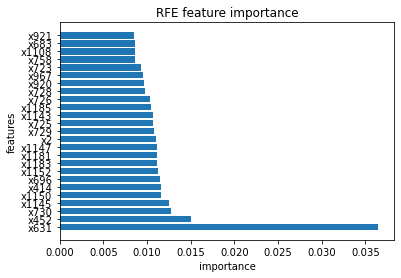

In [64]:
data_importance = {"feature": features_rf, "importance": rf_importance}
df_importance = pd.DataFrame(data_importance).sort_values(by = ['importance'], ascending = False)
top_features_df = df_importance[0:25]

plt.barh(top_features_df.feature, top_features_df.importance)
plt.title('RFE feature importance')
plt.ylabel('features')
plt.xlabel('importance')
plt.show()

In [58]:
train_X_no_outlier_final = train_X_no_outlier[features_rf]
# train_X_no_outlier_final['personid'] = train_data.personid[train_X_scaled.outliers == 1]

In [ ]:
# warnings.filterwarnings('ignore')

# Set of parameters to perform Cross-validation

parameters = {'eta': [0.1, 0.15, 0.2, 0.25, 0.3],
              'gamma':[0.1, 0.15, 0.2, 0.25, 0.3], 'subsample': [1],
              'max_depth': [2, 3], 'lambda': [0.25, 0.35, 0.5], "min_child_weight": [3 4]}
xgb = XGBClassifier(eval_metric='mlogloss')
clf_xgb = GridSearchCV(xgb, param_grid = parameters, scoring = "neg_log_loss")
xgb_model = clf_xgb.fit(train_X_no_outlier_final, train_no_outlier.health) # the final XGBoost model

In [28]:
print(xgb_model.best_score_)
xgb_model.best_estimator_

-1.1965552908253767


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.15, eval_metric='mlogloss', gamma=0.075, gpu_id=-1,
              importance_type=None, interaction_constraints='', lambda=0.6,
              learning_rate=0.150000006, max_delta_step=0, max_depth=2,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=0.600000024, scale_pos_weight=None,
              subsample=1, tree_method='exact', ...)

In [59]:
# warnings.filterwarnings('ignore')
xgb = XGBClassifier(eta = 0.15, gamma = 0.075, max_depth = 2, subsample = 1, min_child_weight = 4, eval_metric='mlogloss')
xgb_model = xgb.fit(train_X_no_outlier_final, train_no_outlier.health)

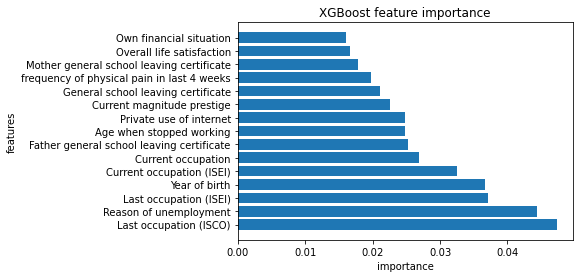

In [81]:
xgb_importance = xgb_model.feature_importances_
data_importance = {"feature": features_rf, "importance": xgb_importance}
df_importance = pd.DataFrame(data_importance).sort_values(by = ['importance'], ascending = False)
top_features_df = df_importance[0:15]

real_names = ["Own financial situation", "Overall life satisfaction", "Mother general school leaving certificate", 
             "frequency of physical pain in last 4 weeks", "General school leaving certificate", "Current magnitude prestige",
             "Private use of internet", "Age when stopped working", "Father general school leaving certificate", 
             "Current occupation", "Current occupation (ISEI)", "Year of birth", "Last occupation (ISEI)", "Reason of unemployment", 
              "Last occupation (ISCO)"]

real_names.reverse()

top_features_df["real_name"] = real_names

plt.barh(top_features_df.real_name, top_features_df.importance)
plt.title('XGBoost feature importance')
plt.ylabel('features')
plt.xlabel('importance')
plt.show()

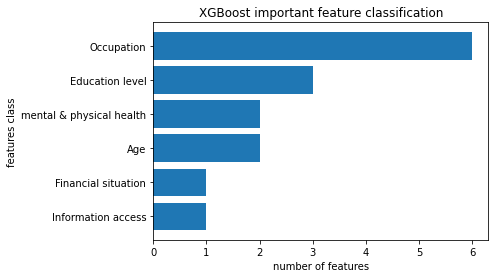

In [85]:
feature_classes = ["Occupation", "Age", "Information access", "Education level", "mental & physical health", 
                  "Financial situation"]
feature_count = [6, 2, 1, 3, 2, 1]
data_important_class = {"Class": feature_classes, "feature_number": feature_count}
data_important_class = pd.DataFrame(data_important_class).sort_values(by = ['feature_number'], ascending = True)
plt.barh(data_important_class.Class, data_important_class.feature_number)
plt.title('XGBoost important feature classification')
plt.ylabel('features class')
plt.xlabel('number of features')
plt.show()

In [23]:
test_data = pd.read_csv("test.csv")

# convert the test dataset to float type
test_data = test_data.astype(float)

# features_rf = features_rf.insert(0, "personid")
test_data_clean = test_data[features_rf]

In [24]:
predict_xgb = xgb_model.predict_proba(test_data_clean)
predict_xgb = pd.DataFrame(predict_xgb, columns = ["p1", "p2", "p3", "p4", "p5"])
predict_xgb.insert(loc = 0, column = 'uniqueid', value = test_data.uniqueid.astype(int))
predict_xgb.to_csv(r'C:\Users\AlecZZX\Desktop\441 data\prediction trials\prediction_12.csv', index = False, header = True)